# Density Estimation
We have seen that clustering algorithms aim to mine the underlying structure of data by breaking it into coherent groups. For example k-means clustering **allows to identify parts of the feature space with high density (i.e., a large number of observations)** by partitioning all observations into a **discrete set of $K$ data groups distributed around centroids**.

An alternative **smoother** approach would be to study the probability $P(X)$, where $X$ is the data. Indeed, if we could determine the probability value of an given point in space $\mathbf{x}$, we could naturally discover clusters in the data (**zones with high probability values**). Knowing the distribution of the data is also useful for a number of things:

* Similar to clustering, if $X$ is a series of observations of customers in a bank (e.g., age, sex, balance, salary, etc.), we may want to know $P(X)$ to understand which types of customers are more frequent (those that have large $P(X)$ values), or if there are different distinct groups of customers (e.g., if $P(X)$ has more than one mode);
* If $X$ is a set of images of faces, knowing $P(X)$ would allow us to understand if an image $x$ looks like an image of a face or not, which faces are more frequent, if there are more than one "groups" of faces, etc. If we could draw $x \sim P$, we could even generate new images of faces! (**by the way, this is what Generative Adversarial Networks do**);
* If $X$ is a series of observations of bank transactions, by modeling $P(X)$ we can infer if a given observation $\mathbf{x}$ is a typical transaction (high $P(\mathbf{x}$)) or whether it is an anomaly (low $P(X)$). If we can make assumptions on the nature of $P(X)$, we can even make inference on the properties of a given data point $\mathbf{x}$. For instance, if $P$ is Gaussian, then datapoints which are further from the center are atypical and they can hence identify anomalous transactions.

A probability density is **a continuous function**, so estimating it is not as straightforward as estimating a **probability mass function**. There are two main classes of methods for density estimation:

* **Non-parametric methods**: these methods aim to estimate the density **directly from the data, without strong assumptions on the source distribution**. The main advantage of these methods is that they generally have few hyper-parameters to tune and can be used when no assumption can be made on the source of the data. A disadvantage is that, while we can numerically compute $f(\mathbf{x})$ with these methods (where $f$ is the density function), we do not know the analytical form or property of $f$;
* **Parametric methods**: these methods aim to **fit a known distribution to the data**. An example of this approach is **fitting a Gaussian to the data**. The main advantage of these methods is that they provide an analytical form for the density $f$, which can be useful in a number of contexts (for instance, the density may be part of a cost function we want to optimize). The downside is that these methods make strong assumptions on the nature of the data.

In the following, we will see the main representatives of these two classes of methods.

## Non-parametric Density Estimation Techniques

We will now look at **non-parametric methods**, which estimate the density *directly from the data* without making strong assumptions (like that the data is Gaussian).

We will focus on the two main approaches:

1.  **Fixed Windows (Histograms):** This method "discretizes" the feature space into a fixed grid of bins and counts how many points fall into each bin.
2.  **Mobile Windows (Kernel Density Estimation):** This method centers a "window" on *every single data point* (or on a grid) and sums their influence, creating a much smoother estimate. This is also known as the **Parzen Window** method.

### Fixed Windows (ND Histograms)

This is the simplest method, extending the 1D histogram to multiple dimensions. We "discretize" the feature space into a fixed grid of "bins" (or "tiles") and count how many points fall into each bin.

A simple *count* is misleading. A bin that is 4x larger might have 4x more points but have the same *density*.

To get a true **probability density function $f(\mathbf{x})$**, our function must satisfy one rule: the **total "volume" under the function must integrate to 1**.

$$
\int f(\mathbf{x}) d\mathbf{x} = 1
$$

To achieve this, we cannot just plot the counts. We must define the density $f(R_i)$ for a bin $R_i$ as the *probability* of that bin divided by its *volume* (or area).

1.  **Probability of the bin:** $P(R_i) = \frac{\text{Count of points in } R_i}{\text{Total Number of Points } (N)}$
2.  **Volume of the bin:** $V(R_i)$ (e.g., for a 2x2 bin, the area is 4).

This gives us the formula for the density *height* of that bin:

$$
f(\mathbf{x} \in R_i) = \frac{P(R_i)}{V(R_i)} = \frac{|R_i| / N}{V(R_i)}
$$

By dividing by the volume, we ensure that a small, crowded bin (small $V(R_i)$) will have a high density value, while a large, sparse bin (large $V(R_i)$) will have a low density value, even if they contain the same number of points. This normalization is what ensures the total volume integrates to 1:


$$
P(\mathbf{x} \in \cup_i R_i) = \sum_i P(R_i) = \sum_i f(\mathbf{x} \in R_i) V(R_i) = \sum_i \frac{|R_i| / N}{V(R_i)} V(R_i) = \frac{1}{N} \sum_i |R_i| = 1
$$

This approach has two main hyperparameters: the **bin size** and the **grid's origin (position)**. A popular alternative to square bins is `hexbin`, which uses hexagonal bins that tile the space more naturally.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


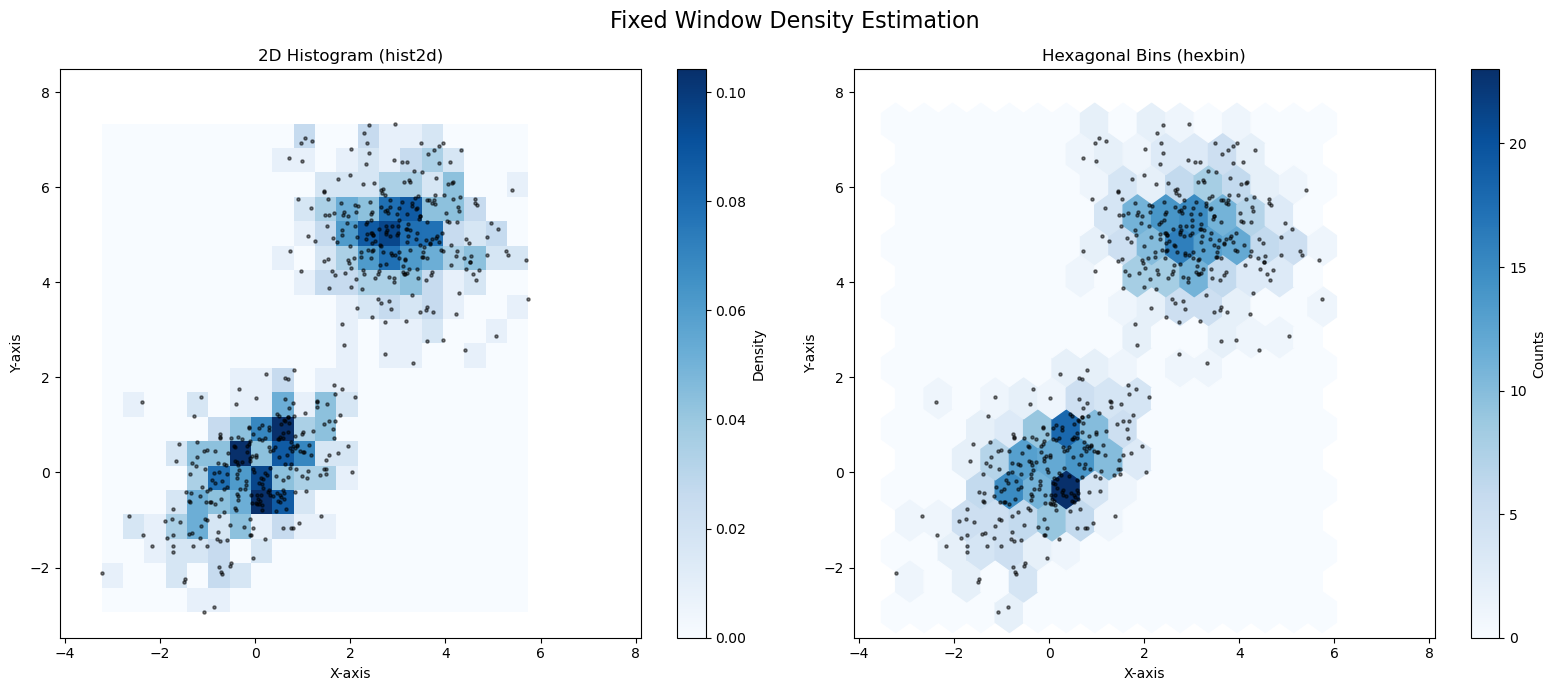

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random 2D points (same data for both plots)
np.random.seed(42)
data1 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size=250)
data2 = np.random.multivariate_normal([3, 5], [[1, -0.2], [-0.2, 1]], size=250)
data = np.concatenate([data1, data2])

# --- Create a side-by-side plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Fixed Window Density Estimation', fontsize=16)

# --- Plot 1: 2D Histogram (Square Bins) ---
# We use density=True to show the probability density, not raw counts
h = ax1.hist2d(data[:, 0], data[:, 1], bins=20, cmap='Blues', density=True)
ax1.scatter(data[:, 0], data[:, 1], c='black', s=5, alpha=0.5)  # Overlay points
ax1.set_title('2D Histogram (hist2d)')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.axis('equal')
fig.colorbar(h[3], ax=ax1, label='Density') # Add a colorbar

# --- Plot 2: Hexagonal Binning (Hex Bins) ---
# We use gridsize to control the number of bins
hb = ax2.hexbin(data[:, 0], data[:, 1], gridsize=15, cmap='Blues')
ax2.scatter(data[:, 0], data[:, 1], c='black', s=5, alpha=0.5)  # Overlay points
ax2.set_title('Hexagonal Bins (hexbin)')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.axis('equal')
fig.colorbar(hb, ax=ax2, label='Counts') # Colorbar for counts

# Set common limits for a good comparison
for ax in (ax1, ax2):
    ax.set_xlim([-3, 7])
    ax.set_ylim([-3, 8])

plt.tight_layout()
plt.show()

As you can see, both plots do a good job of finding the two high-density "blobs" in our data. The `hexbin` plot (right) often looks a bit smoother and more natural than the `hist2d` (left).

The main problem with "fixed window" methods is that the *bin size* is a difficult hyperparameter to choose. More importantly, the rigid, fixed grid is sensitive to where the points fall (the "bin edge" problem).

While we saw this in 2D, we can generalize it to N dimensions (e.g., squares become cubes or hypercubes).

## Method 2: Mobile Windows (Kernel Density Estimation)

The "fixed window" (histogram) method has two main problems:
1.  The "bin edges" are arbitrary and can change the shape of the density.
2.  The resulting density is "blocky" and not smooth.

A more flexible and powerful non-parametric approach is to use a **"mobile window"**. This method is known as **Kernel Density Estimation (KDE)** or the **Parzen Window** method.

Instead of putting a fixed grid over the data, KDE places a "window" (or **kernel**) at each point in space $\mathbf{x}$ and asks, "How much data is inside this window?"

### The "Naive" Approach: The Circular Kernel

A simple approach is to center a circle (or hypersphere) of a fixed radius $h$ at a point $\mathbf{x}$ and calculate the density based on how many data points $N(\mathbf{x},h)$ fall inside it.

This follows the same logic as the histogram:
> Density = (Probability of being in the window) / (Volume of the window)

$$f(\mathbf{x}) = \frac{|N(\mathbf{x},h)| / N}{V(h)}$$

where $N$ is the total number of points, $|N(\mathbf{x},h)|$ is the count of points inside the circle

$$N(\mathbf{x},h) = \{\mathbf{x}' \in \mathbf{X}\ s.t.\ ||\mathbf{x}' - \mathbf{x}||_2 \leq h \}$$

and $V(h)$ is the volume (or area) of the circle (e.g., $V(h) = \pi h^2$).

It is not hard to see that under the definition above, we have:

$$\int_{\mathbf{x} \in \Re^d} f(\mathbf{x}) d\mathbf{x}= 1$$

The plot below shows some density estimates using this method:

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


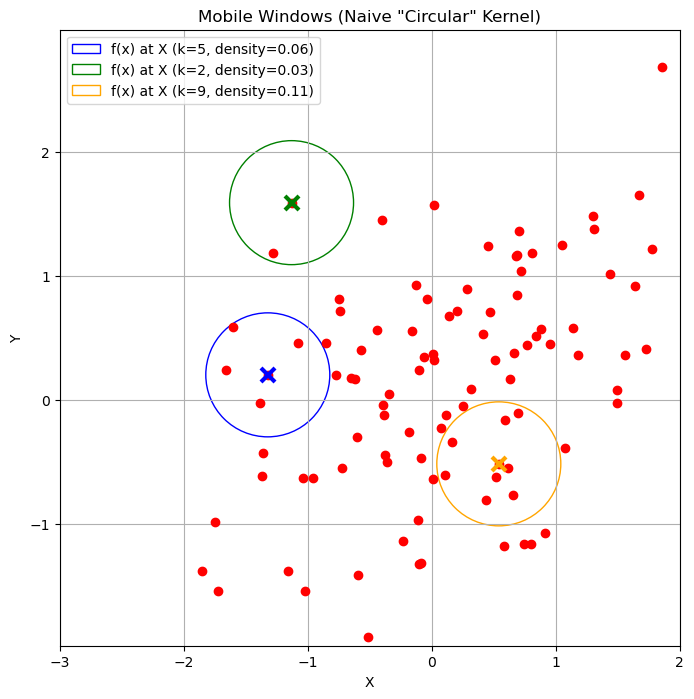

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random 2D points
np.random.seed(42)
data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size=100)

# Create a square bin plot
plt.figure(figsize=(8,8))

plt.plot(data[:,0],data[:,1],'o',color='red')
plt.title('Mobile Windows (Naive "Circular" Kernel)')
nc = 3
colors = ['blue', 'green', 'orange']
h = 0.5 # Our bandwidth

for i in range(nc):
    # Pick a random point 'c' to evaluate
    c = data[np.random.choice(len(data))]
    plt.plot(c[0],c[1], 'x',color=colors[i], markersize=10, mew=3)
    
    # Count how many neighbors fall inside
    nn = ((data[:,0]-c[0])**2+(data[:,1]-c[1])**2 < h**2).sum()
    
    # Calculate the volume (area) of the kernel
    volume = np.pi * h**2
    
    # Calculate the density
    density = (nn / len(data)) / volume
    
    circle = plt.Circle(c, h, edgecolor=colors[i], facecolor='none', 
                        label=f"f(x) at X (k={nn}, density={density:.2f})")
    plt.gca().add_patch(circle)

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.xticks(np.arange(-3,8))
plt.yticks(np.arange(-3,8))
plt.xlim([-3,2])
plt.ylim([-2,3])
plt.legend()
plt.grid()
plt.show()

### Kernel View

We can also write the expression above as:

$$f(\mathbf{x}) = \frac{1}{|\mathbf{X}|} \sum_{i=1}^{|\mathbf{X}|} K_h\left(\mathbf{x}_i - \mathbf{x}\right) $$

where $K_h$ is defined as:

$$K_h\left(\mathbf{x}_i - \mathbf{x}\right) = \begin{cases} \frac{1}{V(h)} & \text{if } ||\frac{\mathbf{x}_i - \mathbf{x}}{h}||_2 \leq 1 \\ 0 & \text{otherwise} \end{cases}$$

We will call $K_h$ **a kernel function** depending on the bandwidth parameter $h$. This is a function which assigns a weight to a point $\mathbf{x}_i$ depending on its distance from $\mathbf{x}$. In the example above, we chose $K_h$ as **a circular (or radial) kernel** which assigns a uniform score to all points falling in a circle of radius $h$ centered at $\mathbf{x}$.

A main problem with this density estimation approach is that **it can be very sensitive to the location at which we are computing the density**. Indeed, we can find cases in which we obtain very different densities when we move the circle by a little bit.

We can note that **this is due by the kernel $K$ making "hard decisions" on which elements to assign a non-zero score and which ones to assign a zero score**. Indeed, if we plot the kernel as a function of the distance between $\mathbf{x}$ and $\mathbf{x}_i$, rescaled by $h$, we obtain the following picture:

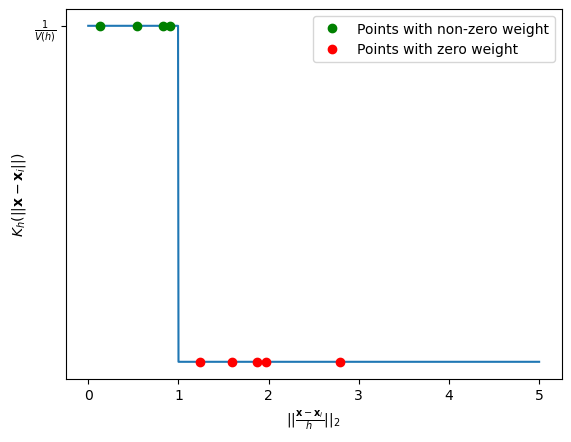

In [9]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(44)
x = np.linspace(0,5,1000)
y = np.ones(len(x))*1/(np.pi)
dd = np.random.normal(0,1.5,20)
dd1 = dd[(dd>0) & (dd<=1)]
dd2 = dd[dd>1]
y[x>1] = 0

plt.plot(x,y)
plt.xlabel('$||\\frac{\\mathbf{x}-\\mathbf{x}_i}{h}||_2$')
plt.ylabel('$K_h(||\\mathbf{x}-\\mathbf{x}_i||)$')
plt.yticks([y[0]],["$\\frac{1}{V(h)}$"])
plt.plot(dd1,np.ones_like(dd1)/np.pi,'o', color='green', label='Points with non-zero weight')
plt.plot(dd2,np.zeros_like(dd2),'o', color='red', label='Points with zero weight')
plt.legend()
plt.show()



The figure above plots points putting their distance from $\mathbf{x}$ in the x axis and the assigned weight in the y axis. As can be noted, even very close points in the x axis (e.g., the last of the green ones and the first of the red ones) get assigned very different weights, which makes the overall process sensitive to small shifts in $\mathbf{x}$.

### The Problem with the "Naive" Kernel

This "circular" (or "radial") kernel has a major flaw: it makes **"hard decisions"**. A point is either 100% "in" the circle (and gets a full vote) or 100% "out" (and gets a 0 vote).

This means that if you move the center $\mathbf{x}$ just a tiny bit, a data point might fall out of the circle, causing the density to "jump" abruptly. This creates a non-smooth, "bumpy" density estimate.


### The Solution: "Smooth" Kernels

To fix this, we use a **smooth kernel** that assigns decreasing weight to points as their distance from the center $\mathbf{x}$ grows. The **Gaussian Kernel** is a reasonable choice:

$$K_h(\mathbf{x}_i - \mathbf{x}) \propto \exp\left(-\frac{\|\mathbf{x}_i - \mathbf{x}\|^2}{2h^2}\right)$$

With a smooth kernel, all points contribute to the density at $\mathbf{x}$, but nearby points contribute *much more* than faraway points.

The general formula for Kernel Density Estimation is a "sum of kernels," one for each data point:

$$f(\mathbf{x}) = \frac{1}{N} \sum_{i=1}^{N} K_h\left(\mathbf{x}_i - \mathbf{x}\right) $$

We can visualize this kernel as follows:

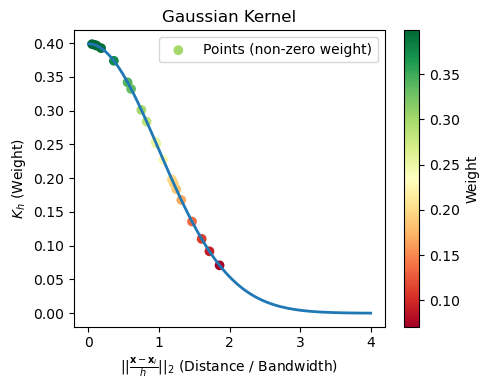

In [21]:
_, axs = plt.subplots(figsize=(5,4), nrows=1,ncols=1)
np.random.seed(44)
x = np.linspace(0,4,100) # Plot from 0 to 3
dd = np.abs(np.random.normal(0,1,20)) # Distances
dd1 = dd[dd<=1]
dd2 = dd[dd>1]
h=1 # Assume bandwidth h=1

i=0
y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x**2)
dd1y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * dd1**2)
dd2y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * dd2**2)
axs.set_title("Gaussian Kernel")
ddd = np.concatenate([dd1,dd2])
dddy = np.concatenate([dd1y,dd2y])
sc = axs.scatter(ddd,dddy, c=dddy, cmap='RdYlGn',label='Points (non-zero weight)')
plt.colorbar(sc, ax=axs, label='Weight')

axs.plot(x,y, lw=2)
axs.set_xlabel(r'$||\frac{\mathbf{x}-\mathbf{x}_i}{h}||_2$ (Distance / Bandwidth)')
axs.set_ylabel(r'$K_h$ (Weight)')
axs.legend(loc='upper right')

plt.tight_layout()
plt.show()

### The Epanechnikov Kernel
The Guassian Kernel solves the sensitivity problem. However, it is very expensive to compute. Indeed, for every new density estimate, we have to compute and sum Gaussian terms over the whole dataset. This can be expensive if we have a large dataset.

An alternative is to set to zero all elements which are far enough. This saves a lot of computation.

This is exactly what the Epanechnikov does. It is defined as follows:


$$K_h(\mathbf{x}_i - \mathbf{x}) = \frac{3}{4h^2} \left(1 - \frac{\|\mathbf{x}_i - \mathbf{x}\|^2}{h^2}\right) \mathbb{I}(\|\mathbf{x}_i - \mathbf{x}\| \leq h)$$

where $\mathbb{I}$ is the indicator function defined as:

$$\mathbb{I}(x) = \begin{cases} 1 & \text{if } x \text{ is true} \\ 0 & \text{otherwise}\end{cases}$$


The plot below compares the scores assigned to points depending on their distance from $\mathbf{x}$ according to the three kernels seen so far:

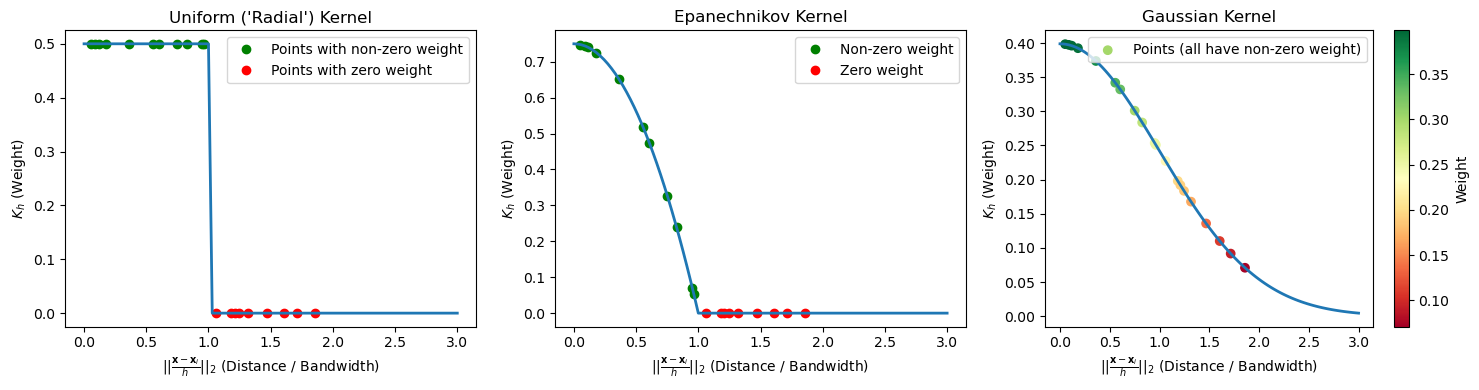

In [22]:
_, axs = plt.subplots(figsize=(15,4), nrows=1,ncols=3)
np.random.seed(44)
x = np.linspace(0,3,100) # Plot from 0 to 3
dd = np.abs(np.random.normal(0,1,20)) # Distances
dd1 = dd[dd<=1]
dd2 = dd[dd>1]
h=1 # Assume bandwidth h=1

for i in range(3):
    if i==0:
        y = np.ones(len(x)) * (1/2) # 1D Volume V(h) = 2*h = 2
        y[x>1] = 0
        dd1y = np.ones_like(dd1) * (1/2)
        dd2y = np.zeros_like(dd2)
        axs[i].set_title("Uniform ('Radial') Kernel")
        axs[i].plot(dd1,dd1y,'o', color='green', label='Points with non-zero weight')
        axs[i].plot(dd2,dd2y,'o', color='red', label='Points with zero weight')
    elif i==1:
        y = 0.75 * (1 - x**2)
        y[x>1] = 0
        dd1y = 0.75 * (1 - dd1**2)
        dd2y = np.zeros_like(dd2)
        axs[i].set_title("Epanechnikov Kernel")
        axs[i].plot(dd1,dd1y,'o', color='green', label='Non-zero weight')
        axs[i].plot(dd2,dd2y,'o', color='red', label='Zero weight')
    elif i==2:
        y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * x**2)
        dd1y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * dd1**2)
        dd2y = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * dd2**2)
        axs[i].set_title("Gaussian Kernel")
        ddd = np.concatenate([dd1,dd2])
        dddy = np.concatenate([dd1y,dd2y])
        sc = axs[i].scatter(ddd,dddy, c=dddy, cmap='RdYlGn',label='Points (all have non-zero weight)')
        plt.colorbar(sc, ax=axs[i], label='Weight')

    axs[i].plot(x,y, lw=2)
    axs[i].set_xlabel(r'$||\frac{\mathbf{x}-\mathbf{x}_i}{h}||_2$ (Distance / Bandwidth)')
    axs[i].set_ylabel(r'$K_h$ (Weight)')
    axs[i].legend()

plt.tight_layout()
plt.show()

The effect of the kernels on the density estimations processes can be seen in the following plot:

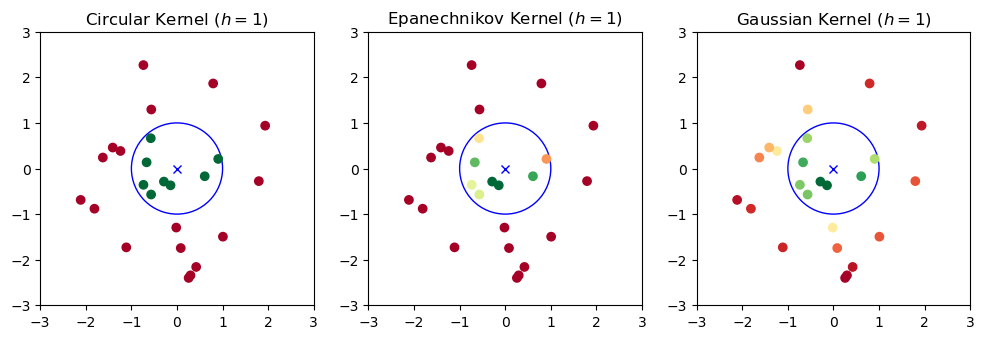

In [23]:
np.random.seed(42)
data = np.random.multivariate_normal((0,0),np.eye(2)*1.5,25)

_,axes=plt.subplots(nrows=1,ncols=3, figsize=(12,4))

h=1

for i in range(3):
    axes[i].add_patch(plt.Circle((0,0),h,facecolor='none', edgecolor='blue'))
    axes[i].plot(0,0,'xb')

    if i==0:
        y = np.ones_like(data[:,0])/np.pi
        y[(data[:,0]**2 + data[:,1]**2)>h**2]=0
        axes[i].set_title('Circular Kernel ($h=1$)')
    elif i==1:
        dist2 = (data[:,0]**2 + data[:,1]**2)
        y = (3/4*(1-dist2**2))
        y[(data[:,0]**2 + data[:,1]**2)>h**2]=0
        axes[i].set_title('Epanechnikov Kernel ($h=1$)')
    elif i==2:
        dist2 = (data[:,0]**2 + data[:,1]**2)
        y = np.ones(len(data[:,0]))*(1/(2*np.pi)**2)*np.exp(-dist2/2)
        axes[i].set_title('Gaussian Kernel ($h=1$)')

    
    axes[i].scatter(data[:,0], data[:,1], c=y, cmap='RdYlGn')
    
    axes[i].set_aspect('equal')
    axes[i].set_xlim([-3,3])
    axes[i].set_ylim([-3,3])

plt.show()

### The Bias-Variance Tradeoff: Choosing the Bandwidth $h$

The kernel shape (e.g., Gaussian) is not the most important choice. The **bandwidth ($h$)** is the *single most important hyperparameter* in density estimation. It controls the **bias-variance tradeoff**.

* **Small $h$ (e.g., `bandwidth = 0.1`):**
    * **Low Bias, High Variance.**
    * The model "trusts" only a tiny local area. The resulting density is "spiky" and "noisy." It **overfits** to the training data.
* **Large $h$ (e.g., `bandwidth = 1.0`):**
    * **High Bias, Low Variance.**
    * The model "blurs" the data by averaging over a huge area. The resulting density is "over-smoothed." It **underfits**, hiding the true structure (like the two separate clusters).

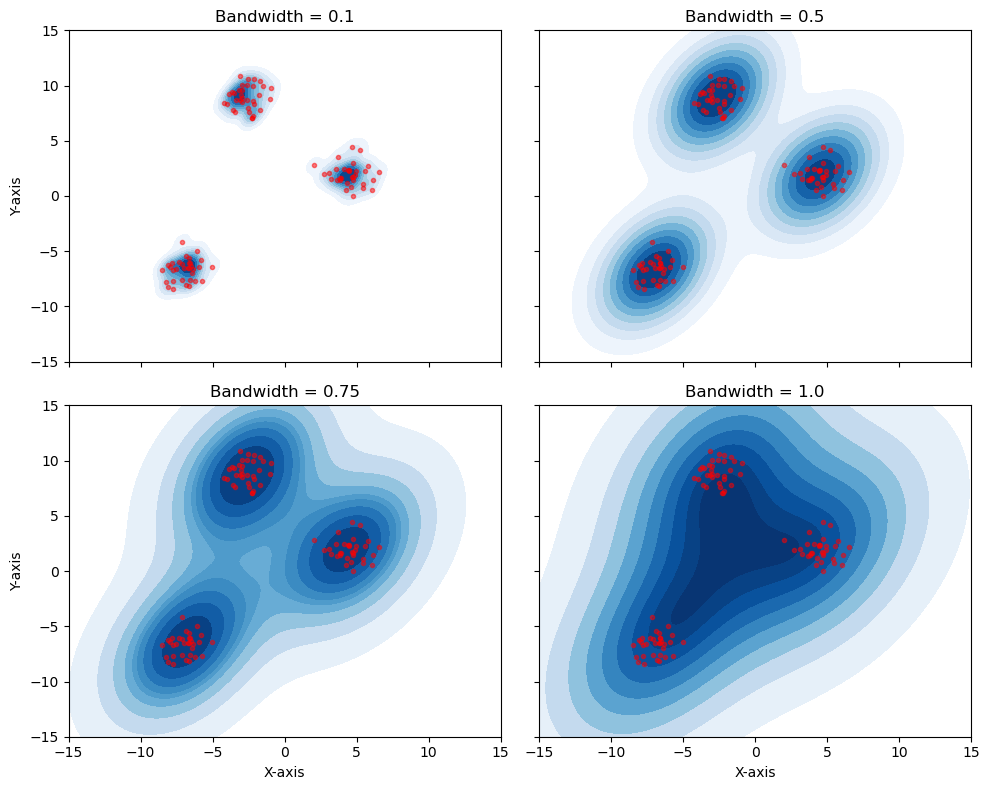

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate synthetic data
np.random.seed(42)
#data = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.5], [0.5, 1]], size=100)
data,_=make_blobs(100,n_features=2,centers=3)


# Bandwidth values to try
bandwidths = [0.1, 0.5, 0.75, 1.0]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for i, bandwidth in enumerate(bandwidths):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    
    # Plot KDE with different bandwidths
    sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap='Blues', fill=True, bw_method=bandwidth, ax=ax)
    ax.plot(data[:,0], data[:,1], '.r', alpha=0.5)
    
    ax.set_title(f'Bandwidth = {bandwidth}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_xlim([-15,15])
    ax.set_ylim([-15,15])

plt.tight_layout()
plt.show()


### Final Result: KDE

As we can see, choosing a good bandwidth (like $h=0.5$ or $h=0.75$) is critical.

When we use a good kernel (like Gaussian) and a well-chosen bandwidth, we can produce a smooth, accurate, and non-parametric estimate of the true data density. The `seaborn.kdeplot` function does all of this for us automatically.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


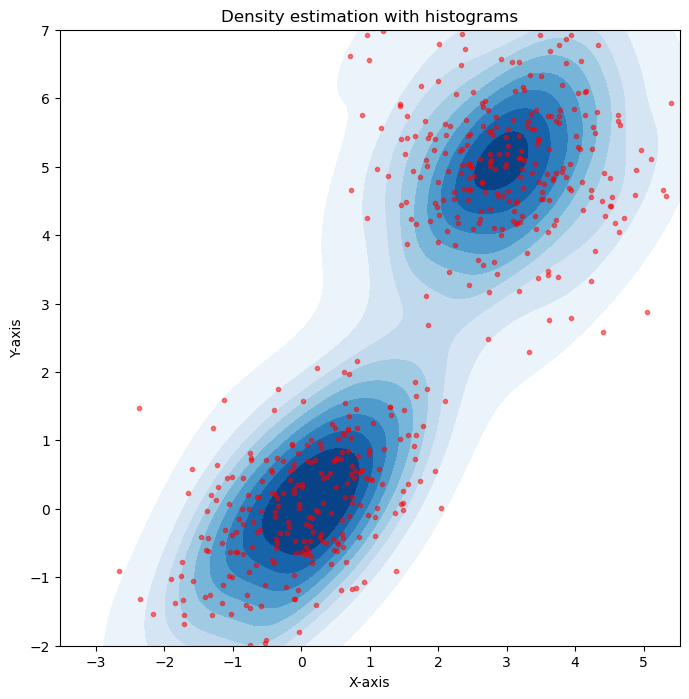

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random 2D points
np.random.seed(42)
data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size=250)
data2 = np.random.multivariate_normal([3, 5], [[1, -0.2], [-0.2, 1]], size=250)

data = np.concatenate([data, data2])

# Set the size of the bins (adjust as needed)
bin_size = 0.5

# Calculate the range of the plot
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

# Calculate the number of bins in each dimension
num_x_bins = int((x_max - x_min) / bin_size)
num_y_bins = int((y_max - y_min) / bin_size)

# Create a square bin plot
plt.figure(figsize=(8, 8))
plt.plot(data[:,0],data[:,1],'.r', alpha=0.5)
sns.kdeplot(x=data[:, 0], y=data[:, 1], cmap='Blues', fill=True)

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis('equal')
plt.title('Density estimation with histograms')

plt.xticks(np.arange(-3,8))
plt.yticks(np.arange(-3,8))
plt.xlim([-3,5])
plt.ylim([-2,7])
#plt.grid()

# Display the plot
plt.show()


## Parametric Density Estimation
Parametric methods aim to estimate density by **fitting a parametric model to the data**. This has some advantages over non-parametric density estimation:

* **The chosen model has in general a known analytical formulation which we can reason on**, or that we can even plug into a cost function and differentiate to pursue some optimization objective;
* **The chosen model is compact.** While non-parametric models need to keep in memory the whole dataset to make density estimations at given points, once fitted, parametric models can be used to predict density values using the analytical formulation of the model;
* **If we choose an interpretable model, we can reason on the model to derive properties of the data.** For instance, if we fit a Gaussian on the data, then we know that the mean is the point with highest density. We also know that when we go further from the mean, the density values decrease;
* **Parametric approaches impose constraints and hence work better when we do not have much data**. Non-parametric approaches, instead, make very little assumptions on the data, so they are better suited to the cases in which we have large datasets which are good representatives of the population.

Nevertheless, these methods also have disadvantages:

* **An optimization process is required** to fit the model to the data, i.e., find appropriate values which make the model "explain well the data". This can be a time-consuming process.
* Parametric models make **strong assumptions on the data**. For instance, if we fit a Gaussian to the data, we assume that the data is distributed in a Gaussian way. If this is not true, then the model will not be very accurate. This is a relevant point, as in many cases we cannot make strong assumptions on the data.

For the reasons above, **it is common to use non-parametric density estimations for visualizations** (e.g., the density plots we have seen and used in many cases), especially for exploration, when we do not know much about the data, and to use parametric model when we need to create efficient models able to make predictions (as we will see later in the course).

### Fitting a Gaussian to the Data

The most common parametric method is to assume our data follows a **Multivariate Gaussian (Normal) Distribution**.

Recall the PDF (Probability Density Function) for a $d$-dimensional Gaussian:

$$N\left( \mathbf{x;\mu,}\mathbf{\Sigma} \right) = \frac{1}{\sqrt{(2\pi)^{d}\det(\Sigma)}} e^{ - \frac{1}{2}\left( \mathbf{x} - \mathbf{\mu} \right)^{T}\Sigma^{- 1}\left( \mathbf{x} - \mathbf{\mu} \right)}$$

This entire, complex distribution is defined by only two parameters:
* The mean vector $\mathbf{\mu}$ (the center of the cloud).
* The covariance matrix $\mathbf{\Sigma}$ (the shape and orientation of the cloud).

Our task is to find the $\mathbf{\mu}$ and $\mathbf{\Sigma}$ that **best fit our data $\mathbf{X}$**.

#### Maximum Likelihood Estimation (MLE)

Let $\mathbf{X} = \{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$ be a set of observations which we will assume to be **independent and drawn from a multivariate Gaussian distribution of unknown parameters**. We would like to find the parameters $\mathbf{\mu}$ and $\mathbf{\Sigma}$ that identify the **most likely Gaussian distribution that may have generated the data**. To do so, we can use the **Maximum Likelihood (ML)** principle, which consists in finding the parameters which maximize the probability values that the Gaussian distribution would compute for the given data. The likelihood is defined as

$$P(\mathbf{X}|\mathbf{\mu},\mathbf{\Sigma}) = \prod_i \mathcal{N}(\mathbf{x}_i|\mathbf{\mu}, \mathbf{\Sigma})$$

In practice, we maximize the log-likelihood instead.

Intuitively, this works as follows:
1.  We "try" a specific Gaussian (a given $\mathbf{\mu}$ and $\mathbf{\Sigma}$).
2.  We calculate the probability density (the "likelihood") of *all* of our data points under this Gaussian.
3.  We multiply these probabilities together to get the **Total Likelihood** of our entire dataset.
4.  The goal is to find the *one* $\mathbf{\mu}$ and $\mathbf{\Sigma}$ that **maximize this total likelihood**.



This sounds like a complex optimization problem, but for a Gaussian distribution, a closed-form solution exists. It can be shown by taking the derivative of the log-likelihood (the log of the likelihood function) and setting it to zero.

Let us consider a simple example in which we want to fit a Gaussian to a set of 1D data. The plot below shows the log likelihood for Gaussians with different means and standard deviations.

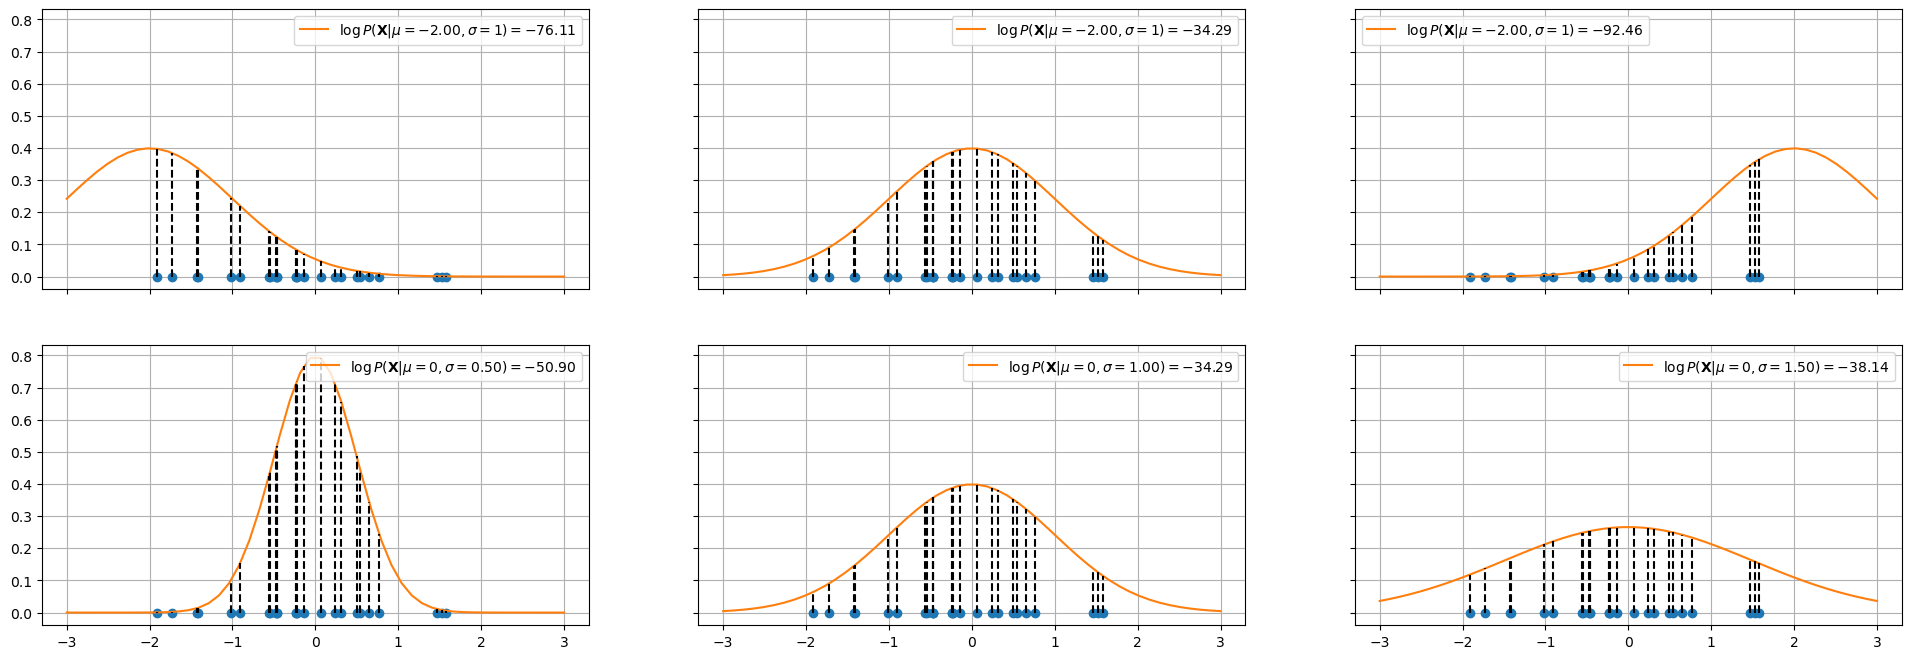

In [34]:
from scipy.stats import norm
np.random.seed(42)
data = np.random.normal(0, 1, 25)

_, axs = plt.subplots(figsize=(24,8), nrows=2, ncols=3, sharex=True, sharey=True)

i=0
mus = [-2, 0, 2]
for j in range(3):
    axs[i][j].plot(data, np.zeros_like(data),'o')

    likelihood = norm.pdf(data, mus[j], 1).prod()

    x = np.linspace(-3,3)
    axs[i][j].plot(x, norm.pdf(x, mus[j], 1), label="$\log P(\\mathbf{X}|\\mu={"+f"{mus[i]:0.2f}"+"},\\sigma=1)={"+f"{np.log(likelihood):0.2f}"+"}$")

    for d in data:
        axs[i][j].plot([d,d], [0,norm.pdf(d, mus[j], 1)], '--k')
        
    if j<2:
        axs[i][j].legend(loc='upper right')
    else:
        axs[i][j].legend(loc='upper left')
    axs[i][j].grid()


i=1
sigmas = [0.5, 1, 1.5]
for j in range(3):
    axs[i][j].plot(data, np.zeros_like(data),'o')

    likelihood = norm.pdf(data, 0, sigmas[j]).prod()

    x = np.linspace(-3,3)
    axs[i][j].plot(x, norm.pdf(x, 0, sigmas[j]), label="$\log P(\\mathbf{X}|\\mu=0,\\sigma="+f"{sigmas[j]:0.2f}"+")={"+f"{np.log(likelihood):0.2f}"+"}$")

    for d in data:
        axs[i][j].plot([d,d], [0,norm.pdf(d, 0, sigmas[j])], '--k')
        
    axs[i][j].legend(loc='upper right')
    axs[i][j].grid()
plt.show()

In the top plots, the standard deviation is fixed to $1$, while the mean of the Gaussian is changed. The log likelihood is shown in the legend. As can be seen, the mean in the center plot leads to a larger log likelihood. **Intuitively, this happens when we choose a mean such that the majority of points fall in the central part of the Gaussian distribution**.

**The plots in the bottom show a similar example in which the mean is fixed to $0$ and the standard deviation is varied**. As can be noted, when the standard deviation is too low (left) or to high (right), we obtain smaller log likelihoods.

The plots below show the log likelihood (first two plots) or the likelihood (last plot) as a function of different values of means and standard deviations.

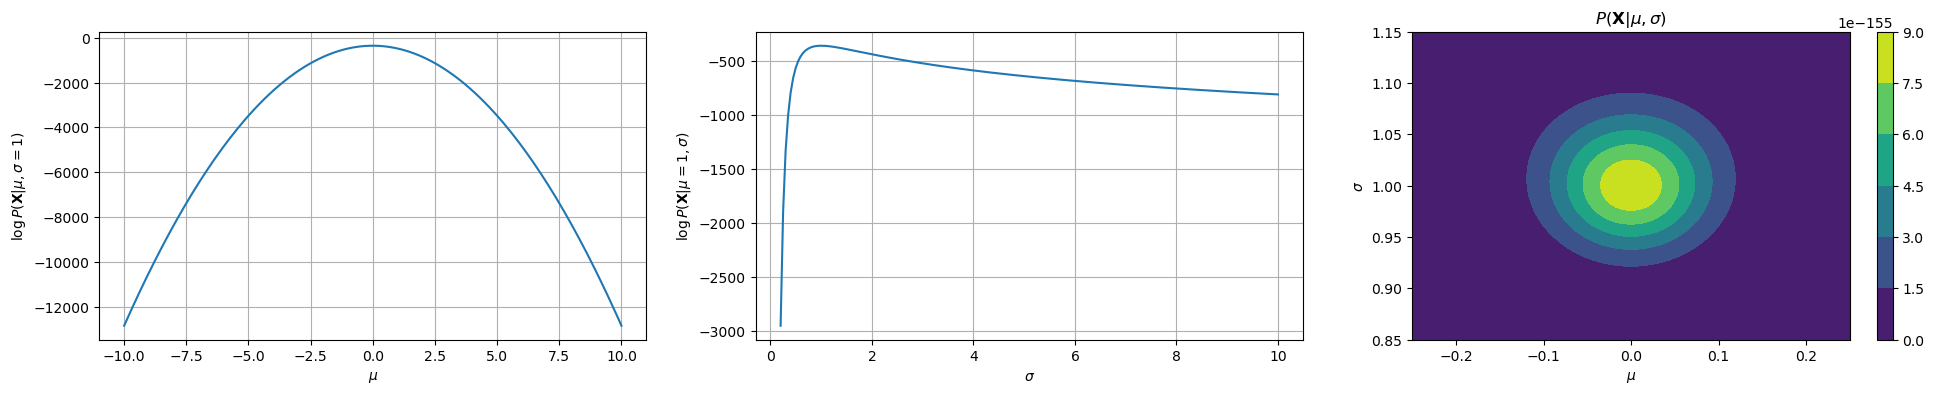

In [38]:
from scipy.stats import norm
np.random.seed(42)
data = np.random.normal(0, 1, 250)
data = data -data.mean()
data = data/data.std()

mus = np.linspace(-10,10,200)
sigmas = np.linspace(0.2,10,200)

_, axs = plt.subplots(figsize=(24,4), nrows=1, ncols=3)

lks_mu = []
for mu in mus:
    lks_mu.append(np.log(norm.pdf(data, mu, 1)).sum())

lks_sigma = []
for sigma in sigmas:
    lks_sigma.append(np.log(norm.pdf(data, 0, sigma)).sum())

axs[0].plot(mus, lks_mu)
axs[0].grid()
axs[0].set_xlabel("$\\mu$")
axs[0].set_ylabel("$\log P(\\mathbf{X}|\\mu, \\sigma=1)$")

axs[1].plot(sigmas, lks_sigma)
axs[1].grid()
axs[1].set_xlabel("$\\sigma$")
axs[1].set_ylabel("$\log P(\\mathbf{X}|\\mu=1, \\sigma)$")

X,Y = np.meshgrid(np.linspace(-0.25,0.25,100),np.linspace(0.85,1.15,100))

lks = []
for x,y in zip(X.ravel(), Y.ravel()):
    lks.append(norm.pdf(data, x, y).prod())

lks = np.array(lks).reshape(X.shape)

axs[2].set_title('$P(\\mathbf{X}|\\mu,\\sigma)$')
c = axs[2].contourf(X,Y,lks)
axs[2].set_xlabel("$\\mu$")
axs[2].set_ylabel("$\\sigma$")
plt.colorbar(c,ax=axs[2])

plt.show()

The first two plots show how the log likelihood changes when $\mu$ and $\sigma$ change, keeping the data fixed (same data as the previous plot). The last plot shows how the likelihood changes as a function of both $\mu$ and $\sigma$. As we can see, we have a maximum for $\mu=0$ and $\sigma=1$, which are the true parameters of the distribution which generated the data.

#### The Solution: Sample Mean and Covariance

The final result is incredibly intuitive. The Maximum Likelihood estimates for the Gaussian parameters are simply:

**1. The ML estimate for the mean ($\mathbf{\mu}_{ML}$) is the sample mean:**

$$\mathbf{\mu}_{ML} = \frac{1}{N} \sum_{i=1}^N \mathbf{x}_i$$

**2. The ML estimate for the covariance ($\mathbf{\Sigma}_{ML}$) is the sample covariance matrix:**

$$\mathbf{\Sigma}_{ML} = \frac{1}{N} \sum_{i=1}^N (\mathbf{x}_i - \mathbf{\mu}_{ML})(\mathbf{x}_i - \mathbf{\mu}_{ML})^T$$

*(Note: In statistics, you often see a $1/(N-1)$ denominator for an "unbiased" estimate. The $1/N$ is the true Maximum Likelihood estimate, but in practice, they are nearly identical.)*

**In short: "Fitting a Gaussian" is just a fancy way of saying "calculating the mean and covariance of your data."**

### The Weakness of a Single Gaussian: Bimodal Data

The single Gaussian model we just learned is powerful, but it's based on one very strong assumption: that our data comes from a *single cluster* (i.e., it is **unimodal**).

This assumption fails for many real-world datasets. A perfect example is the "Old Faithful" `geyser` dataset, which we know from our clustering lecture is **bimodal** (it has two distinct clusters).

What happens if we try to fit our simple parametric model (a single Gaussian) to this bimodal data? Let's compare it to the non-parametric KDE, which we know can find the true shape.

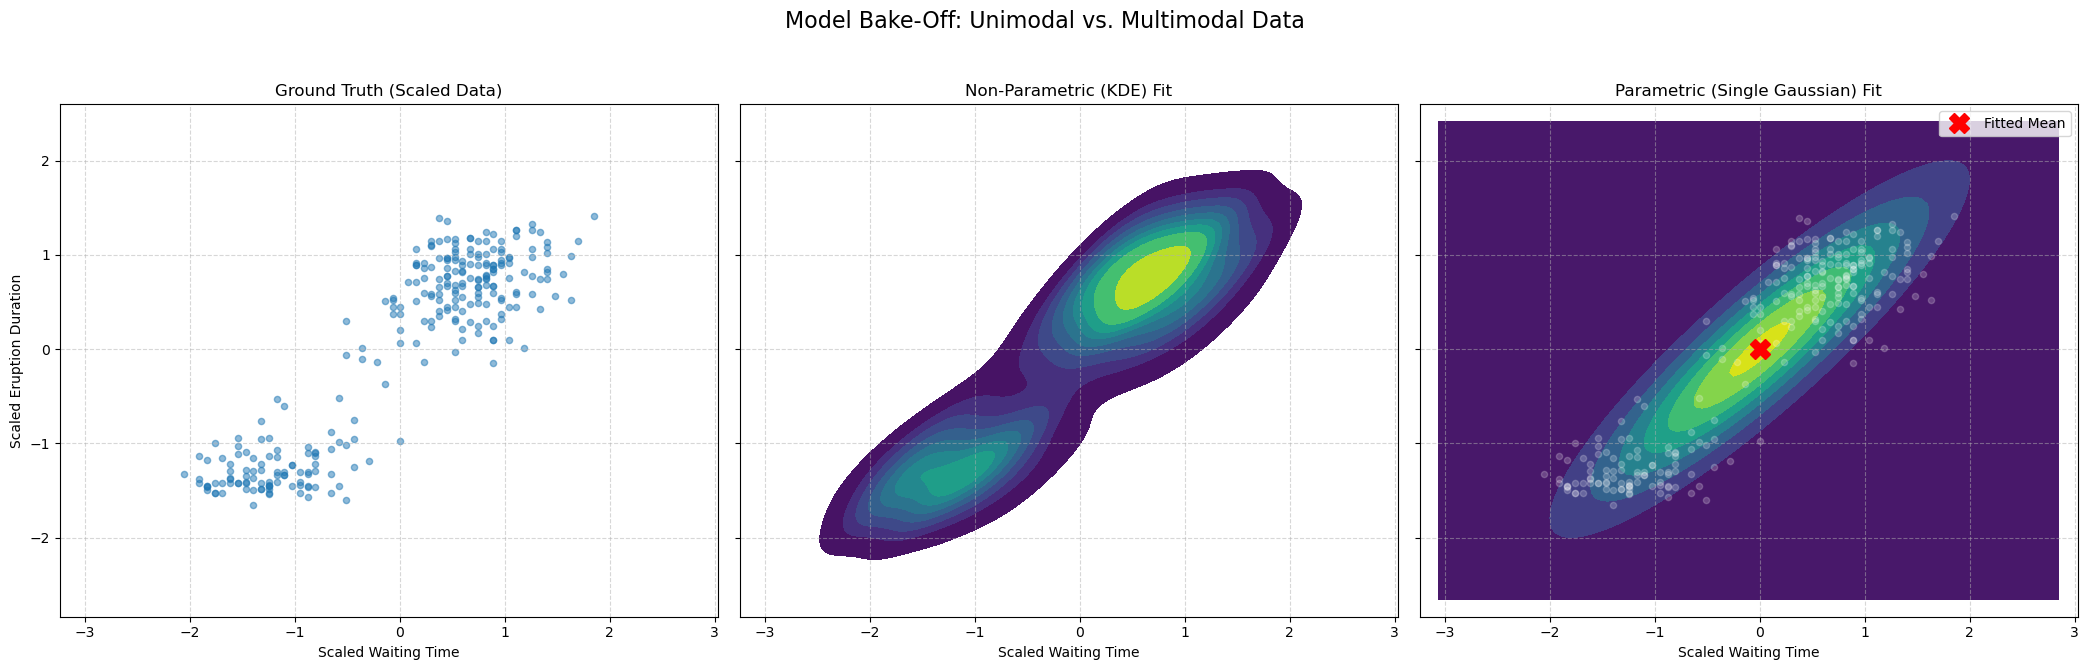

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal

# Load and scale the geyser data
df = sns.load_dataset('geyser')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['waiting', 'duration']])

# --- 1. Fit the Single Gaussian (Parametric) ---
# We get the ML estimates (the sample mean and covariance)
mu_ml = np.mean(X_scaled, axis=0)
sigma_ml = np.cov(X_scaled.T)
single_gaussian = multivariate_normal(mean=mu_ml, cov=sigma_ml)

# --- 2. Create a grid for plotting ---
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x, y)
pos = np.dstack((xx, yy))

# --- 3. Create the 3-panel plot ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)
fig.suptitle('Model Bake-Off: Unimodal vs. Multimodal Data', fontsize=16)

# Plot 1: The "Ground Truth"
ax1.scatter(X_scaled[:, 0], X_scaled[:, 1], s=20, alpha=0.5)
ax1.set_title('Ground Truth (Scaled Data)')
ax1.set_xlabel('Scaled Waiting Time')
ax1.set_ylabel('Scaled Eruption Duration')
ax1.grid(True, linestyle='--', alpha=0.5)

# Plot 2: Non-Parametric KDE
sns.kdeplot(x=X_scaled[:, 0], y=X_scaled[:, 1], cmap='viridis', fill=True, ax=ax2)
ax2.set_title('Non-Parametric (KDE) Fit')
ax2.set_xlabel('Scaled Waiting Time')
ax2.grid(True, linestyle='--', alpha=0.5)

# Plot 3: Parametric Single Gaussian
pdf_values = single_gaussian.pdf(pos)
ax3.contourf(xx, yy, pdf_values, cmap='viridis')
ax3.scatter(X_scaled[:, 0], X_scaled[:, 1], s=20, alpha=0.2, color='white')
ax3.plot(mu_ml[0], mu_ml[1], 'rX', markersize=15, label='Fitted Mean')
ax3.set_title('Parametric (Single Gaussian) Fit')
ax3.set_xlabel('Scaled Waiting Time')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The result is clear:
* The **KDE plot (middle)** correctly finds the two high-density clusters. It is flexible and *non-parametric*, so it doesn't care that the data isn't a single "blob."
* The **Single Gaussian plot (right)** *fails*. It places its mean (the red 'X') in the empty, low-density space *between* the two clusters. It's a "unimodal" model trying to fit "bimodal" data.

This proves the limitation of our simple parametric model. To solve this, we need a more powerful parametric model that can *learn* to model multi-modal data.

## Gaussian Mixture Models (GMM)

Our comparison showed a critical weakness: our simple parametric model, a single Gaussian, failed to capture the **bimodal** (two-cluster) structure of the `geyser` data. The non-parametric KDE *did* find the shape, but it doesn't give us a compact, mathematical model.

This leads to the obvious question: Can we create a *parametric* model that is flexible enough to handle multi-modal data?

Yes. The solution is a **Gaussian Mixture Model (GMM)**.

The idea is simple: instead of one Gaussian, we model the data as a **weighted average (a "mixture") of $K$ different Gaussian components**.

$$P(\mathbf{x}) = \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k, \mathbf{\Sigma}_k)$$

This model is defined by three sets of parameters:
* **$\pi_k$ (Mixing Coefficients):** The "weight" or prior probability of each component. (e.g., $\pi_1=0.6, \pi_2=0.4$). Must sum to 1.
* **$\mathbf{\mu}_k$ (Means):** The center of each of the $K$ Gaussian components.
* **$\mathbf{\Sigma}_k$ (Covariances):** The shape and orientation of each of the $K$ components.

The 1D plot below shows a GMM with $K=3$. The final density (red-dashed) is a *mixture* of three separate Gaussian components (blue, orange, green), allowing it to model complex, multi-modal data.

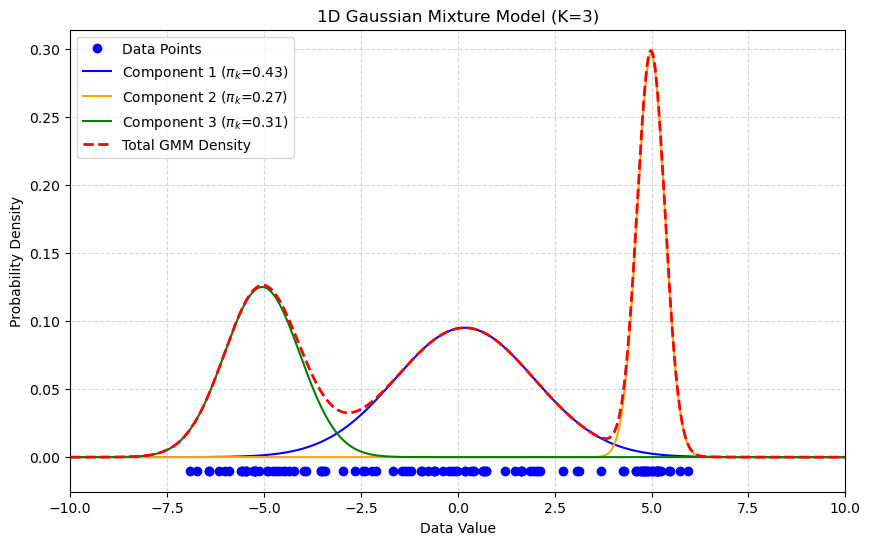

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Generate synthetic 1D data
np.random.seed(42)
data = np.concatenate([
    np.random.normal(loc=-5, scale=1, size=30),
    np.random.normal(loc=0, scale=2, size=50),
    np.random.normal(loc=5, scale=0.5, size=30)
])
data = data.reshape(-1, 1)

# Fit a GMM with 3 components
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(data)

# Generate data for plotting
x = np.linspace(-10, 10, 1000).reshape(-1, 1)

# Plot the GMM
plt.figure(figsize=(10, 6))
plt.plot(data, np.zeros_like(data) - 0.01, 'ob', label='Data Points')

# Plot the individual components
colors = ['blue', 'orange', 'green']
for i in range(gmm.n_components):
    component_pdf = gmm.weights_[i] * norm.pdf(x, loc=gmm.means_[i, 0], scale=np.sqrt(gmm.covariances_[i, 0, 0]))
    plt.plot(x, component_pdf, label=f'Component {i+1} ($\pi_k$={gmm.weights_[i]:0.2f})', color=colors[i])

# Plot the total GMM density
pdf = np.exp(gmm.score_samples(x))
plt.plot(x, pdf, '--', color='red', lw=2, label='Total GMM Density')

plt.title('1D Gaussian Mixture Model (K=3)')
plt.xlabel('Data Value')
plt.ylabel('Probability Density')
plt.xlim([-10, 10])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### GMM Density Estimation Example

Now let's apply this to our `geyser` data. When we fit a GMM with $K=2$, it should succeed where the single Gaussian failed.

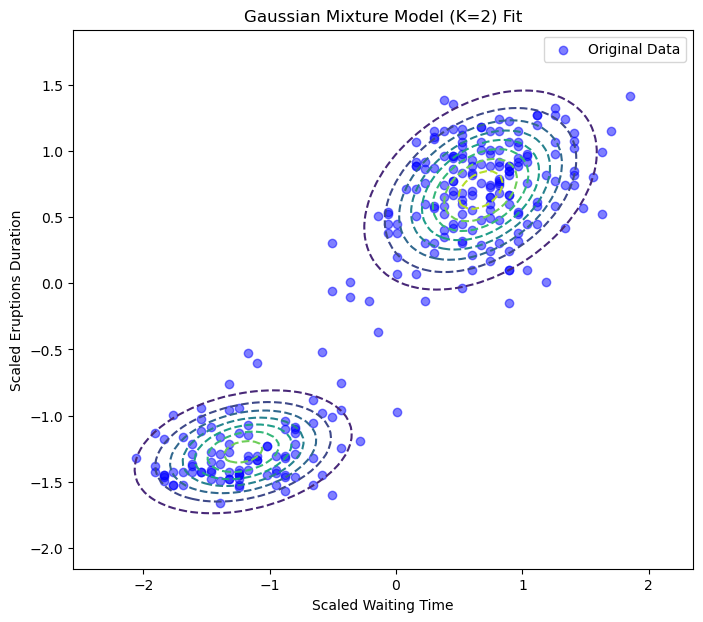

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load Old Faithful dataset from seaborn
df = sns.load_dataset("geyser")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['waiting', 'duration']])

# Fit a Gaussian Mixture Model to the data
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

# Create a figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

# Create a grid for plotting contours
x = np.linspace(X_scaled[:, 0].min()-0.5, X_scaled[:, 0].max()+0.5, 100)
y = np.linspace(X_scaled[:, 1].min()-0.5, X_scaled[:, 1].max()+0.5, 100)
xx, yy = np.meshgrid(x, y)
pos = np.dstack((xx, yy))

# Evaluate the GMM PDF on the meshgrid
pdf_values = np.exp(gmm.score_samples(pos.reshape(-1, 2)))
pdf_values = pdf_values.reshape(100, 100)

# Scatter plot of the original data and GMM fit
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], color='blue', alpha=0.5, label='Original Data')
ax.contour(xx, yy, pdf_values, levels=10, cmap='viridis', linestyles='dashed')
ax.set_xlabel('Scaled Waiting Time')
ax.set_ylabel('Scaled Eruptions Duration')
ax.set_title('Gaussian Mixture Model (K=2) Fit')
ax.legend()
plt.show()

Success! The GMM has learned two distinct Gaussian components that perfectly model the two clusters in our data.

### GMM as "Soft Clustering"
GMM can be seen as a "soft" version of K-Means. If K-Means makes a hard assignment of data points to clusters, it can be shown that GMM does it in a "soft" way, computing instead the probability of assigning an element to a cluster.

It does this by introducing a **latent variable**, $Z$ encoding the event:

> The example $\mathbf{x}$ belongs to a given cluster.

In practice, $Z=k$ denotes the case in which $X=\mathbf{x}$ belongs to cluster $k$.

A **latent variable** is a "hidden" variable for which we don't observe ground-truth values, but which we assume is intrinsically part of the data. In this GMM, for every data point $\mathbf{x}_i$, there is a hidden $z_i$ that "indicates" which of the $K$ Gaussian components *generated* that point.

To compute the soft assignment, we find the **posterior probability**, $P(Z=k | \mathbf{x})$: "What is the probability that this point $\mathbf{x}$ belongs to cluster $k$?"

We solve this using **Bayes' Theorem** to "flip" the question:

$$
P(Z=k | \mathbf{x}) = \frac{P(\mathbf{x} | Z=k) P(Z=k)}{P(\mathbf{x})}
$$

Once the GMM is trained (which we'll see how to do later with the E-M algorithm), we *have* all the pieces for this formula:

1.  **$P(\mathbf{x} | Z=k)$ (The Likelihood):**
    * *In words:* "What is the probability of seeing $\mathbf{x}$ *if* it came from cluster $k$?"
    * *The value:* This is simply the value of our $k$-th Gaussian component: $\mathcal{N}(\mathbf{x}|\mathbf{\mu}_k, \mathbf{\Sigma}_k)$.

2.  **$P(Z=k)$ (The Prior):**
    * *In words:* "How common is cluster $k$ in general?"
    * *The value:* This is our mixing coefficient, $\pi_k$.

3.  **$P(\mathbf{x})$ (The Evidence):**
    * *In words:* "What is the total probability of seeing $\mathbf{x}$ under *any* cluster?"
    * *The value:* This is just the sum of all components, which is our GMM formula: $\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}|\mathbf{\mu}_j, \mathbf{\Sigma}_j)$.

Putting it all together, the "soft assignment" (or **responsibility**, $\gamma_k$) for a point $\mathbf{x}$ belonging to cluster $k$ is:

$$
\gamma_k = P(Z=k|\mathbf{x}) = \frac{\pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k, \mathbf{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}|\mathbf{\mu}_j, \mathbf{\Sigma}_j)}
$$

This formula is exactly what is being used to generate the colors in the plot below. Points in the middle get an "uncertain" color (like yellow, $\approx 0.5$) because their probability is split between the two components.

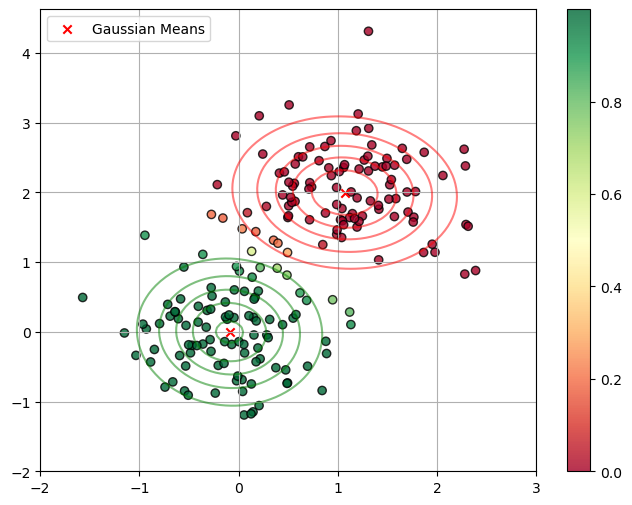

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_openml


np.random.seed(42)
plt.figure(figsize=(8,6))
data, labels = make_blobs(n_samples=200,n_features=2, centers=[(0,0),(1,2)], cluster_std=0.6)

# Fit a Gaussian Mixture Model (GMM) with 2 components to the data
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data)
responsibilities = gmm.predict_proba(data)

# Plot the data points with different shades of color based on responsibilities
scatter=plt.scatter(data[:, 0], data[:, 1], c=responsibilities[:,0], cmap='RdYlGn', marker='o', edgecolors='k', alpha=0.8)

x, y = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-2, 4, 100))
grid = np.c_[x.ravel(), y.ravel()]

pdf_values = [weight * multivariate_normal(mean, cov).pdf(grid)
              for mean, cov, weight in zip(gmm.means_, gmm.covariances_, gmm.weights_)]

pdf1, pdf2 = pdf_values

# Reshape PDF values for contour plotting
pdf_values = np.sum(pdf_values, axis=0).reshape(x.shape)

# Plot the GMM components and contours
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], color='red', marker='x', label='Gaussian Means')

plt.contour(x, y, np.array(pdf1).reshape(x.shape), levels=5, colors='green', alpha=0.5)
plt.contour(x, y, np.array(pdf2).reshape(x.shape), levels=5, colors='red', alpha=0.5)

# Plot the means of the Gaussian components
#plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', marker='X', s=200, label='Gaussian Means')
plt.colorbar(mappable=scatter)

# Add labels and legend
plt.legend()
plt.grid()

# Show the plot
plt.show()


### How to "Learn" a GMM: Optimization by Maximum Likelihood

We have defined our GMM as a sum of weighted Gaussians:
$$P(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k, \mathbf{\Sigma}_k)$$

The model's parameters are all the means, covariances, and mixing coefficients:
$$\mathbf{\theta} = (\mathbf{\pi}, \mathbf{\mu}, \mathbf{\Sigma}) = \{\pi_1, \ldots, \pi_K, \mathbf{\mu}_1, \ldots, \mathbf{\mu}_K, \mathbf{\Sigma}_1, \ldots, \mathbf{\Sigma}_K\}$$

To "fit" the model, we use **Maximum Likelihood Estimation (MLE)**, just as we did for a single Gaussian. We want to find the parameters $\mathbf{\theta}$ that maximize the log-likelihood of our observed data $\mathbf{X} = \{\mathbf{x}_1, \ldots, \mathbf{x}_N\}$:

$$\log P(\mathbf{X}|\mathbf{\theta}) = \sum_{i=1}^N \log\left[\sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x_i}|\mathbf{\mu}_k, \mathbf{\Sigma}_k)\right]$$

This problem can not be optimized directly. Instead, a dedicated algorithm called Expectation-Maximization is used. We will not see this in details.

### GMM vs K-Means
The EM algorithm is very similar to the optimization algorithm of K-Means. It can be shown that K-Means can be seen as a particular case of Gaussian Mixture Models in which:
* Points are assigned to clusters in a "*hard*" way, as compared to the **soft assignment** made by the responsibilities $\gamma(z_{ik})$ in Gaussian Mixture Models;
* Clusters are assumed to have diagonal covariance matrices $\epsilon \mathbf{I}$ where $\mathbf{I}$ is the $D \times D$ identity matrix and $\epsilon$ is a variance parameter which is **shared by all components**. This means that the clusters are assumed to be all **symmetrical and with the same shape**.

Despite these differences highlight the limitations of K-Means, it should be considered that K-Means is a significantly faster algorithm than GMM. Hence, if studying the probability density $P(\mathbf{X})$ is not needed and we can assume symmetrical clusters with similar shapes, K-Means is in practice a more popular choice, due to its faster convergence.

The plot below illustrates such differences:

/var/folders/cs/p62_d78d49n3ddj0xlfh1h7r0000gn/T/ipykernel_41205/782823674.py:44: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(xx, yy, density, colors='red', levels=5, linewidth=2)


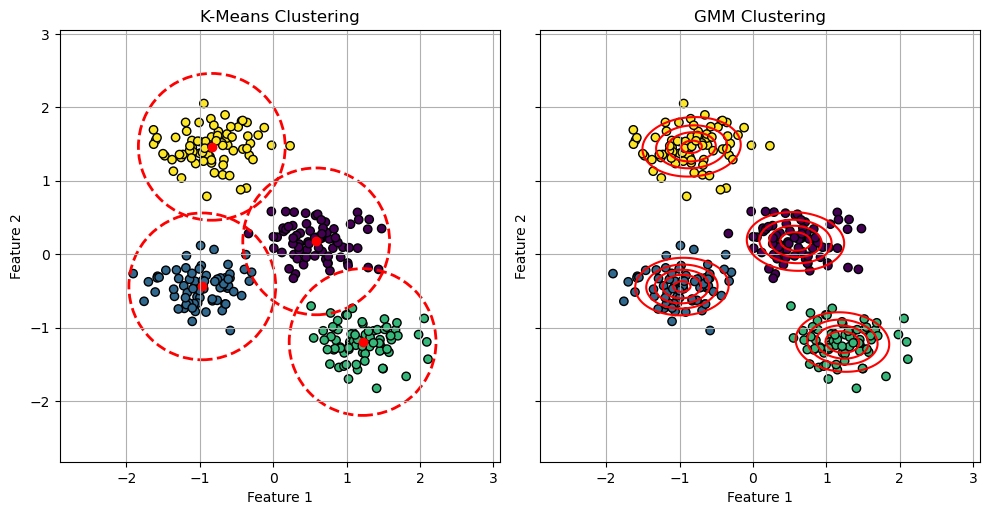

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate skewed synthetic data
np.random.seed(42)
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
X[:, 1] = X[:, 1] * 3 + 10  # Add skewness to the data

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
kmeans_centers = kmeans.cluster_centers_

# Apply Gaussian Mixture Model (GMM) clustering
gmm = GaussianMixture(n_components=4, random_state=0)
gmm.fit(X)
gmm_labels = gmm.predict(X)

# Function to plot circles around k-means cluster centers
def plot_kmeans_circles(kmeans, ax):
    for i in range(len(kmeans.cluster_centers_)):
        circle = plt.Circle(kmeans.cluster_centers_[i], 1, color='red', fill=False, linestyle='dashed', linewidth=2)
        ax.add_artist(circle)

# Function to plot density estimation for each Gaussian component in GMM
def plot_gmm_density(gmm, ax):
    h = 0.02  # Step size of the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    positions = np.c_[xx.ravel(), yy.ravel()]
    density = np.sum([coef * multivariate_normal(mean, cov).pdf(positions) for coef, mean, cov in zip(gmm.weights_, gmm.means_, gmm.covariances_)], axis=0)
    density = density.reshape(xx.shape)

    ax.contour(xx, yy, density, colors='red', levels=5, linewidth=2)

# Plotting
_, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True)

# Plot k-means results with circles around cluster centers
axs[0].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', edgecolors='k')
axs[0].scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='red', marker='o', label='Cluster Centers')
plot_kmeans_circles(kmeans, axs[0])
axs[0].set_title('K-Means Clustering')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
axs[0].set_aspect('equal')
axs[0].grid()
#axs[0].legend()

# Plot GMM results with density estimation
axs[1].scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', edgecolors='k')
plot_gmm_density(gmm, axs[1])
axs[1].set_title('GMM Clustering')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 2')

axs[1].set_aspect('equal')
axs[1].grid()
# Show the plot
plt.tight_layout()
plt.show()


## Lab: Density Estimation for Anomaly Detection

In this lab, we will use our density estimation techniques to build a more complex **Anomaly Detector**.

### The Goal
Our task is to build a model that can identify the digit **'0'** as an "anomaly."

1.  **"Normal" Training Data:** We will train our models on a large dataset of "normal" digits (all images of '1's, '2's, '3's, ... '9's). This "normal" data is highly **multi-modal** (it has 9 distinct clusters).
2.  **Test Data:** We will then create a test set containing a mix of "normal" digits (1-9) and "anomalous" digits ('0's).
3.  **The "Bake-Off":** We will compare three models to see which is best at this task:
    * **Model 1 (Single Gaussian):** A "naive" parametric model. We expect this to fail, as it will try to fit one "average" blob over all 9 normal digits.
    * **Model 2 (GMM):** A "smart" parametric model. We will tell it to fit $K=4$ components, to capture some diversity in the data.
    * **Model 3 (KDE):** A "flexible" non-parametric model.

A good model will give a **high density score** to the "normal" digits and a **very low score** to the "anomalous" '0's.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import roc_curve, auc

### Step 1: Load and Prepare the Data

We'll load the `digits` dataset and split it into three groups:
1.  `X_train_normal`: A training set of 70% of all "normal" digits (1-9).
2.  `X_test_normal`: A test set of 30% of all "normal" digits (1-9).
3.  `X_test_anomaly`: *All* of the "anomalous" digit '0's.

In [64]:
# 1. Load Data
X_all, y_all = load_digits(return_X_y=True)

# 2. Separate "normal" (1-9) from "anomaly" (0)
X_normal_all = X_all[y_all != 0]
y_normal_all = y_all[y_all != 0]

X_anomaly_all = X_all[y_all == 0]
y_anomaly_all = np.ones(len(X_anomaly_all)) # Label 1 = Anomaly

# 3. Create our Train/Test split
# We split the "normal" data into a train and test set
X_train_normal, X_test_normal, _, _ = train_test_split(
    X_normal_all, y_normal_all, test_size=0.3, random_state=42, stratify=y_normal_all
)
y_test_normal = np.zeros(len(X_test_normal)) # Label 0 = Normal

# 4. Create the final test set
X_test = np.concatenate((X_test_normal, X_anomaly_all))
y_test = np.concatenate((y_test_normal, y_anomaly_all))

print(f"Training data (Normal, 1-9): {X_train_normal.shape}")
print(f"Test data (Mixed): {X_test.shape}")
print(f"  -> Normal '1-9's in test: {len(X_test_normal)}")
print(f"  -> Anomalous '0's in test:  {len(X_anomaly_all)}")

Training data (Normal, 1-9): (1133, 64)
Test data (Mixed): (664, 64)
  -> Normal '1-9's in test: 486
  -> Anomalous '0's in test:  178


### Step 2: Preprocessing (Scaling)

We will fit a `StandardScaler` *only* on our `X_train_normal` data and use it to transform both our train and test sets.

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)

### Step 3: Fit the Density Models

Now we will fit our three competitors to the **`X_train_scaled`** data (which contains 9 different clusters of digits).

In [83]:
# 1. Fit the Single Gaussian (Unimodal Parametric)
# This model will try to find the "average" of all 9 digits.
print("Fitting Single Gaussian (K=1)...")
model_single_gauss = GaussianMixture(n_components=1, random_state=42)
model_single_gauss.fit(X_train_scaled)

# 2. Fit the GMM (Multi-modal Parametric)
print("Fitting GMM (K=4)...")
model_gmm = GaussianMixture(n_components=4, random_state=42)
model_gmm.fit(X_train_scaled)

# 3. Fit the KDE (Non-Parametric)
# We'll use a bandwidth found from experimentation
print("Fitting KDE...")
model_kde = KernelDensity(kernel='gaussian')
model_kde.fit(X_train_scaled)

print("All three models are trained on the '1-9' digits.")

Fitting Single Gaussian (K=1)...
Fitting GMM (K=4)...
Fitting KDE...
All three models are trained on the '1-9' digits.


### Step 4: Get Anomaly Scores

Now we'll use all three models to score our `X_test_scaled` data. We will use the **Negative Log-Likelihood (NLL)** as our "anomaly score."

* `model.score_samples()` returns the log-likelihood (high = normal).
* `-model.score_samples()` returns the NLL.

With NLL, a **low score** means "this point looks normal," and a **high score** means "this point looks weird (anomalous)." This is a more intuitive way to think of an "anomaly score."

In [86]:
# Get the NLL scores for every point in the test set
# (NLL = -LogLikelihood)
scores_single = -model_single_gauss.score_samples(X_test_scaled)
scores_gmm = -model_gmm.score_samples(X_test_scaled)
scores_kde = -model_kde.score_samples(X_test_scaled)

# Store results in a DataFrame for easy plotting
results_df = pd.DataFrame({
    'y_true': y_test, 
    'SingleGaussian_NLL': scores_single, 
    'GMM_K4_NLL': scores_gmm, 
    'KDE_NLL': scores_kde
})

results_df['Label'] = results_df['y_true'].map({0: 'Normal (1-9)', 1: 'Anomaly (0)'})

### Step 5: Quantitative Comparison (The ROC Curve)

The histograms show GMM and KDE are much better, but the **ROC Curve** gives us the definitive quantitative score.

We will plot the **True Positive Rate** (finding the '0's) vs. the **False Positive Rate** (falsely flagging the '1-9's) for all three models. The **Area Under the Curve (AUC)** will be our final metric.

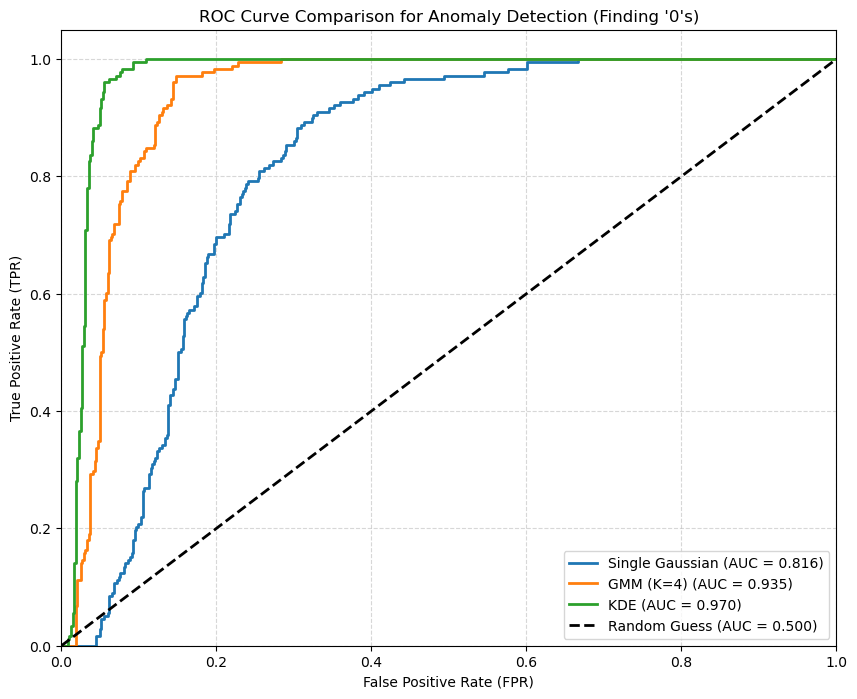

In [87]:
from sklearn.metrics import roc_auc_score

# --- Create the ROC Plot ---
plt.figure(figsize=(10, 8))

# --- 1. Single Gaussian ---
fpr, tpr, _ = roc_curve(results_df['y_true'], results_df['SingleGaussian_NLL'])
auc_single = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'Single Gaussian (AUC = {auc_single:.3f})')

# --- 2. GMM (K=9) ---
fpr, tpr, _ = roc_curve(results_df['y_true'], results_df['GMM_K4_NLL'])
auc_gmm = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'GMM (K=4) (AUC = {auc_gmm:.3f})')

# --- 3. KDE ---
fpr, tpr, _ = roc_curve(results_df['y_true'], results_df['KDE_NLL'])
auc_kde = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'KDE (AUC = {auc_kde:.3f})')

# --- 4. Plot Styling ---
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison for Anomaly Detection (Finding \'0\'s)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

We note that the most flexible density estimation model is the KDE in this case. A single Gaussian oversimplifies the problem, while a GMM adds back some flexibility.

## References
 - https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation
 - https://en.wikipedia.org/wiki/Kernel_density_estimation
 - http://faculty.washington.edu/yenchic/18W_425/Lec7_knn_basis.pdf
 - Section 9.2 of \[1\]
 
 \[1\] Bishop, Christopher M., and Nasser M. Nasrabadi. Pattern recognition and machine learning. Vol. 4. No. 4. New York: springer, 2006.